In [79]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


In [80]:
train_pd = pd.read_csv('sign_mnist_train.csv')

test_pd = pd.read_csv('sign_mnist_test.csv')

In [81]:
train_pd.shape, test_pd.shape

((27455, 785), (7172, 785))

In [82]:
x_train = train_pd.drop(['label'], axis=1).values
y_train = train_pd['label'].values

In [83]:
x_train.shape, y_train.shape

((27455, 784), (27455,))

In [84]:
x_test = test_pd.drop(['label'], axis=1).values
y_test = test_pd['label'].values

In [85]:
x_test.shape, y_test.shape

((7172, 784), (7172,))

In [86]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)


In [87]:
# Normalize the input

x_train = x_train/ 255

x_test= x_test/ 255

batch_size=128

# BASELINE MODEL

In [10]:
#Build the model

model = keras.Sequential([
    keras.layers.Conv2D(20, kernel_size=(3,3), padding='same', activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(40, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(80, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(25, activation='softmax')
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=30, batch_size= batch_size, validation_data=(x_test, y_test))

Epoch 1/30
215/215 [==============================] - 1s 6ms/step - loss: 3.0453 - accuracy: 0.2428 - val_loss: 2.9343 - val_accuracy: 0.3515
Epoch 2/30
215/215 [==============================] - 1s 4ms/step - loss: 2.7413 - accuracy: 0.5527 - val_loss: 2.7461 - val_accuracy: 0.5512
Epoch 3/30
215/215 [==============================] - 1s 4ms/step - loss: 2.6381 - accuracy: 0.6526 - val_loss: 2.7002 - val_accuracy: 0.5859
Epoch 4/30
215/215 [==============================] - 1s 4ms/step - loss: 2.6190 - accuracy: 0.6679 - val_loss: 2.6882 - val_accuracy: 0.5968
Epoch 5/30
215/215 [==============================] - 1s 4ms/step - loss: 2.6017 - accuracy: 0.6845 - val_loss: 2.6596 - val_accuracy: 0.6266
Epoch 6/30
215/215 [==============================] - 1s 4ms/step - loss: 2.5792 - accuracy: 0.7060 - val_loss: 2.6350 - val_accuracy: 0.6535
Epoch 7/30
215/215 [==============================] - 1s 4ms/step - loss: 2.5303 - accuracy: 0.7571 - val_loss: 2.5184 - val_accuracy: 0.7740
Epoch 

In [12]:
loss, acc = model.evaluate(x_test, y_test)

print('test loss: ', loss)
print('test accuracy: ', acc* 100)

225/225 [==============================] - 0s 2ms/step - loss: 2.3170 - accuracy: 0.9689
test loss:  2.3170039653778076
test accuracy:  96.89068794250488


225/225 - 0s - loss: 2.3170 - accuracy: 0.9689

Test accuracy: 96.89068794250488


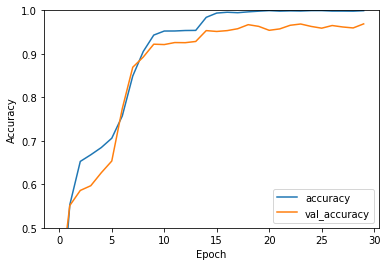

In [13]:
#Evaluate the Model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc*100)

# CONVERTING INTO TFLITE MODEL

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpfak9rrvi/assets


In [15]:
with open('sign_mnist_model.tflite', 'wb') as f:
  f.write(tflite_model)


In [16]:
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(x_test):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == y_test).mean()
  return accuracy

In [17]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('TFLite Test Accuracy:', test_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.


TFLite Test Accuracy: 96.89068600111544


# TFLITE FLOAT- 16 QUANTIZATION

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations= [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types= [tf.float16]
tflite_quant_f16_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp7jn0_mrx/assets


INFO:tensorflow:Assets written to: /tmp/tmp7jn0_mrx/assets


In [19]:
with open('sign_mnist_model_quant_f16.tflite', 'wb') as f:
  f.write(tflite_quant_f16_model)

In [20]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_f16_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('TFLite Quant Float-16 Test Accuracy % :', test_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.


TFLite Quant Float-16 Test Accuracy % : 96.87674288901282


# TFLITE DYNAMIC QUANTIZATION

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_dynamic_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpdfrmomi7/assets


INFO:tensorflow:Assets written to: /tmp/tmpdfrmomi7/assets


In [22]:
with open('sign_mnist_model_quant_dyn.tflite', 'wb') as f:
  f.write(tflite_dynamic_quant_model)

In [23]:
interpreter = tf.lite.Interpreter(model_content=tflite_dynamic_quant_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('TFLite Dynamic Quantization Test Accuracy:', test_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.


TFLite Dynamic Quantization Test Accuracy: 96.93251533742331


# TFLITE INT8 QUATIZATION

In [89]:
x_train= x_train.astype(np.float32)

In [96]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_int8_quant = converter.convert()
with open('sign_mnist_model_quant_int8.tflite', 'wb') as f:
  f.write(tflite_int8_quant)

INFO:tensorflow:Assets written to: /tmp/tmpxgah7c_h/assets


INFO:tensorflow:Assets written to: /tmp/tmpxgah7c_h/assets


In [105]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global x_test

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = x_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


In [106]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_model, model_type):
  global x_test
  global y_test

  test_image_indices = range(x_test.shape[0])
  predictions = run_tflite_model(tflite_model, test_image_indices)

  accuracy = (np.sum(y_test == predictions) * 100) / len(x_test)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(x_test)))

In [107]:
evaluate_model('sign_mnist_model_quant_int8.tflite', model_type="Quantized")

Quantized model accuracy is 96.8210% (Number of test samples=7172)


# Quantization Aware Training

In [44]:
pip install tensorflow_model_optimization

     |████████████████████████████████| 174kB 5.0MB/s 


In [45]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 28, 28, 1)         3         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 28, 28, 20)        243       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 20)        1         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 14, 14, 40)        7323      
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 7, 7, 40)          1         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 7, 7, 80)          29043     
_________________________________________________________________
quant_max_pooling2d_2 (Quant (None, 3, 3, 80)          1

In [50]:
q_aware_model.fit(x_train, y_train,
                  batch_size=128, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
215/215 [==============================] - 2s 11ms/step - loss: 2.2856 - accuracy: 0.9999 - val_loss: 2.3239 - val_accuracy: 0.9619
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 2.2862 - accuracy: 0.9993 - val_loss: 2.3201 - val_accuracy: 0.9658
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 2.2885 - accuracy: 0.9971 - val_loss: 2.3146 - val_accuracy: 0.9713
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 2.2865 - accuracy: 0.9990 - val_loss: 2.3183 - val_accuracy: 0.9681
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 2.2859 - accuracy: 0.9996 - val_loss: 2.3203 - val_accuracy: 0.9653


In [108]:
_, baseline_model_accuracy = model.evaluate(
    x_test, y_test, verbose=0)

_, q_aware_model_accuracy = q_aware_model.evaluate(
   x_test, y_test, verbose=0)



In [110]:
print('Baseline Test Accuracy:', baseline_model_accuracy*100)
print('Quantized Aware Test Accuracy:', q_aware_model_accuracy*100)

Baseline Test Accuracy: 96.89068794250488
Quantized Aware Test Accuracy: 96.52816653251648
